# Striking image

Summarize tree and frequencies for most recent natural data.

In [1]:
# Define inputs.
tree_for_timepoint_t = "../results/auspice/flu_seasonal_h3n2_ha_2y.json"
frequencies_for_timepoint_t = "../results/auspice/flu_seasonal_h3n2_ha_2y_tip-frequencies.json"

# Define outputs.
distance_model_figure = "../manuscript/figures/nextstrain-forecast-strains.pdf"

In [2]:
from augur.utils import json_to_tree
import datetime
import json
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform

from treetime.utils import numeric_date

%matplotlib inline

In [3]:
old_epoch = '0000-12-31T00:00:00'

In [4]:
mdates.set_epoch(old_epoch)

In [5]:
np.random.seed(314159)

In [6]:
sns.set_style("ticks")

In [7]:
# Display figures at a reasonable default size.
mpl.rcParams['figure.figsize'] = (6, 4)

# Disable top and right spines.
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
    
# Display and save figures at higher resolution for presentations and manuscripts.
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 300

# Display text at sizes large enough for presentations and manuscripts.
mpl.rcParams['font.weight'] = "normal"
mpl.rcParams['axes.labelweight'] = "normal"
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

mpl.rc('text', usetex=False)

In [8]:
tip_size = 10
end_date = 2004.3

In [9]:
def float_to_datestring(time):
    """Convert a floating point date from TreeTime `numeric_date` to a date string
    """
    # Extract the year and remainder from the floating point date.
    year = int(time)
    remainder = time - year

    # Calculate the day of the year (out of 365 + 0.25 for leap years).
    tm_yday = int(remainder * 365.25)
    if tm_yday == 0:
        tm_yday = 1

    # Construct a date object from the year and day of the year.
    date = datetime.datetime.strptime("%s-%s" % (year, tm_yday), "%Y-%j")

    # Build the date string with zero-padded months and days.
    date_string = "%s-%.2i-%.2i" % (date.year, date.month, date.day)

    return date_string

In [10]:
def plot_tree_by_datetime(tree, color_by_trait=None, size_by_trait=None, initial_branch_width=5, tip_size=10,
              start_date=None, end_date=None, include_color_bar=False, ax=None, colorbar_ax=None,
              earliest_node_date=None, default_color="#cccccc", default_color_branch="#999999", override_y_values=None,
              cmap=None, default_size=0.001, plot_projection_from_date=None, plot_projection_to_date=None,
              projection_attr="projected_frequency", projection_line_threshold=1e-2, size_scaler=1e3):
    """Plot a BioPython Phylo tree in the BALTIC-style.
    """
    # Plot H3N2 tree in BALTIC style from Bio.Phylo tree.
    if override_y_values is None:
        override_y_values = {}
        
    yvalues = [node.yvalue for node in tree.find_clades()]
    y_span = max(yvalues)
    y_unit = y_span / float(len(yvalues))

    # Setup colors.
    if color_by_trait:
        trait_name = color_by_trait
        
        if cmap is None:
            traits = [k.attr[trait_name] for k in tree.find_clades() if trait_name in k.attr]
            norm = mpl.colors.Normalize(min(traits), max(traits))
            cmap = mpl.cm.viridis

    #
    # Setup the figure grid.
    #

    if ax is None:
        if include_color_bar:
            fig = plt.figure(figsize=(8, 6), facecolor='w')
            gs = gridspec.GridSpec(2, 1, height_ratios=[14, 1], width_ratios=[1], hspace=0.1, wspace=0.1)
            ax = fig.add_subplot(gs[0])
            colorbar_ax = fig.add_subplot(gs[1])
        else:
            fig = plt.figure(figsize=(8, 4), facecolor='w')
            gs = gridspec.GridSpec(1, 1)
            ax = fig.add_subplot(gs[0])

    L=len([k for k in tree.find_clades() if k.is_terminal()])

    # Setup arrays for tip and internal node coordinates.
    tip_circles_x = []
    tip_circles_y = []
    tip_circles_color = []
    tip_circle_sizes = []
    node_circles_x = []
    node_circles_y = []
    node_circles_color = []
    node_line_widths = []
    node_line_segments = []
    node_line_colors = []
    branch_line_segments = []
    branch_line_widths = []
    branch_line_colors = []
    branch_line_labels = []
    projection_line_segments = []

    for k in tree.find_clades(): ## iterate over objects in tree
        x=k.attr["collection_date_ordinal"] ## or from x position determined earlier
        
        if earliest_node_date and x < earliest_node_date:
            continue
        
        if k.name in override_y_values:
            y = override_y_values[k.name]
        else:
            y = k.yvalue ## get y position from .drawTree that was run earlier, but could be anything else

        if k.parent is None:
            xp = None
        else:
            xp=k.parent.attr["collection_date_ordinal"] ## get x position of current object's parent

        #if x==None: ## matplotlib won't plot Nones, like root
        #    x=0.0
        if xp==None:
            xp=x

        c = default_color
        if color_by_trait and trait_name in k.attr:
            if isinstance(cmap, dict):
                c = cmap[k.attr[trait_name]]
            else:
                c = cmap(norm(k.attr[trait_name]))

        branchWidth=initial_branch_width
        if k.is_terminal(): ## if leaf...            
            if size_by_trait is not None and size_by_trait in k.attr:
                s = (size_scaler * np.sqrt(k.attr.get(size_by_trait, default_size)))
            else:
                s = tip_size ## tip size can be fixed

            tip_circle_sizes.append(s)
            tip_circles_x.append(x)
            tip_circles_y.append(y)
            tip_circles_color.append(c)
            
            if plot_projection_to_date is not None and plot_projection_from_date is not None:
                if k.attr.get(projection_attr, 0.0) > projection_line_threshold:
                    future_s = (size_scaler * np.sqrt(k.attr.get(projection_attr)))
                    future_x = plot_projection_to_date + np.random.randint(-60, 0)
                    future_y = y
                    future_c = c

                    tip_circle_sizes.append(future_s)
                    tip_circles_x.append(future_x)
                    tip_circles_y.append(future_y)
                    tip_circles_color.append(future_c)
                    
                    projection_line_segments.append([(x + 1, y), (future_x, y)])
            
        else: ## if node...
            k_leaves = [child
                        for child in k.find_clades()
                        if child.is_terminal()]

            # Scale branch widths by the number of tips.
            branchWidth += initial_branch_width * len(k_leaves) / float(L)

            if len(k.clades)==1:
                node_circles_x.append(x)
                node_circles_y.append(y)
                node_circles_color.append(c)

            ax.plot([x,x],[k.clades[-1].yvalue, k.clades[0].yvalue], lw=branchWidth, color=default_color_branch, ls='-', zorder=9, solid_capstyle='round')

        branch_line_segments.append([(xp, y), (x, y)])
        branch_line_widths.append(branchWidth)
        branch_line_colors.append(default_color_branch)

    branch_lc = LineCollection(branch_line_segments, zorder=9)
    branch_lc.set_color(branch_line_colors)
    branch_lc.set_linewidth(branch_line_widths)
    branch_lc.set_label(branch_line_labels)
    branch_lc.set_linestyle("-")
    ax.add_collection(branch_lc)
    
    if len(projection_line_segments) > 0:
        projection_lc = LineCollection(projection_line_segments, zorder=-10)
        projection_lc.set_color("#cccccc")
        projection_lc.set_linewidth(1)
        projection_lc.set_linestyle("--")
        projection_lc.set_alpha(0.5)
        ax.add_collection(projection_lc)

    # Add circles for tips and internal nodes.
    tip_circle_sizes = np.array(tip_circle_sizes)
    ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes, facecolor=tip_circles_color, edgecolors='#000000', linewidths=0.5, alpha=0.75, zorder=11) ## plot circle for every tip
    #ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes*1.75, facecolor="#000000", edgecolor='none', zorder=10) ## plot black circle underneath
    ax.scatter(node_circles_x, node_circles_y, facecolor=node_circles_color, s=50, edgecolor='none', zorder=10, lw=2, marker='|') ## mark every node in the tree to highlight that it's a multitype tree

    #ax.set_ylim(-10, y_span - 300)

    ax.spines['top'].set_visible(False) ## no axes
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.tick_params(axis='y',size=0)
    ax.set_yticklabels([])

    if start_date:
        ax.set_xlim(left=start_date)

    if end_date:
        ax.set_xlim(right=end_date)

    if include_color_bar:
        cb1 = mpl.colorbar.ColorbarBase(
            colorbar_ax,
            cmap=cmap,
            norm=norm,
            orientation='horizontal'
        )
        cb1.set_label(color_by_trait)

    return ax, colorbar_ax

## Load trees

Load an auspice tree for both timepoint t and timepoint u. The first tree needs to be annotated with the projected frequency at time u and weighted distance to the future.

Both trees need to be annotated with amino acid sequences for the tips as an `aa_sequence` key in each tip's `attr` attribute.

In [11]:
with open(tree_for_timepoint_t, "r") as fh:
    tree_json_for_t = json.load(fh)
    
tree_for_t = json_to_tree(tree_json_for_t)

In [12]:
latest_sample_date_in_t = max([node.node_attrs["num_date"]["value"] for node in tree_for_t.find_clades(terminal=True)])

In [13]:
latest_sample_date_in_t

2020.2445355191257

In [14]:
earliest_date_to_plot = latest_sample_date_in_t - 2.0

Annotate ordinal collection dates from floating point dates on both trees.

In [15]:
for node in tree_for_t.find_clades():
    node.node_attrs["collection_date_ordinal"] = pd.to_datetime(float_to_datestring(node.node_attrs["num_date"]["value"])).toordinal()

## Load frequencies

Load tip frequencies from auspice. These should include a `projected_pivot` key and one or more pivots after that timepoint for each tip.

In [16]:
with open(frequencies_for_timepoint_t, "r") as fh:
    frequencies_for_t = json.load(fh)

In [17]:
pivots = frequencies_for_t.pop("pivots")

In [18]:
projection_pivot = frequencies_for_t.pop("projection_pivot")

In [19]:
projection_pivot_index_for_t = pivots.index(projection_pivot)

In [20]:
frequency_records_for_t = []
for sample, sample_frequencies in frequencies_for_t.items():
    for pivot, sample_frequency in zip(pivots, sample_frequencies["frequencies"]):
        frequency_records_for_t.append({
            "strain": sample,
            "timepoint": float_to_datestring(pivot),
            "pivot": pivot,
            "frequency": sample_frequency
        })

In [21]:
frequency_df_for_t = pd.DataFrame(frequency_records_for_t)

In [22]:
frequency_df_for_t["timepoint"] = pd.to_datetime(frequency_df_for_t["timepoint"])

Annotate trees with frequencies at corresponding timepoints. For the tree at timepoint t, annotate both current and projected frequencies. For the tree at timepoint u, annotate the current frequencies.

In [23]:
pivots[projection_pivot_index_for_t]

2020.25

In [24]:
projection_pivot_index_for_t

24

In [25]:
max_frequency = 0.5

In [26]:
for tip in tree_for_t.find_clades(terminal=True):
    tip.node_attrs["frequency_at_t"] = min(frequencies_for_t[tip.name]["frequencies"][projection_pivot_index_for_t], max_frequency)
    tip.node_attrs["projected_frequency_at_u"] = min(frequencies_for_t[tip.name]["frequencies"][-1], max_frequency)

In [27]:
projection_pivot

2020.25

In [28]:
tips_with_nonzero_frequencies = set()

for tip in tree_for_t.find_clades(terminal=True):
    if tip.node_attrs["frequency_at_t"] > 0:
        tips_with_nonzero_frequencies.add(tip.name)

In [29]:
len(tips_with_nonzero_frequencies)

764

In [30]:
start_date = pd.to_datetime("2018-10-01").toordinal()
end_date = pd.to_datetime("2021-04-15").toordinal()
frequency_end_date = pd.to_datetime("2020-04-01").toordinal()

timepoint_t = pd.to_datetime(float_to_datestring(projection_pivot)).toordinal()

In [31]:
d = pd.to_datetime(float_to_datestring(projection_pivot))

In [32]:
d

Timestamp('2020-03-31 00:00:00')

In [33]:
d.toordinal()

737515

In [34]:
d = datetime.datetime.today()

In [35]:
d.toordinal()

737651

In [36]:
start_date

736968

In [37]:
end_date

737895

In [38]:
frequency_end_date

737516

In [39]:
timepoint_t

737515

In [40]:
timepoint_u = pd.to_datetime(float_to_datestring(projection_pivot + 1)).toordinal()

In [41]:
timepoint_u

737881

In [42]:
frequency_steps = [0, 0.25, 0.5, 0.75, 1.0]

## Plot tree

In [43]:
def get_y_positions(tree):
    """Create a mapping of each clade to its vertical position. Dict of {clade:
    y-coord}. Coordinates are negative, and integers for tips.
    We use the y position layout function from BioPython [1]. This function is
    hidden inside the top-level draw function, so we cannot reuse it.
    [1] https://github.com/biopython/biopython/blob/d1d3c0d6ab33de12057201e09eb48bdb1964521a/Bio/Phylo/_utils.py#L471-L495
    Parameters
    ----------
    tree : Bio.Phylo.BaseTree
        a tree from BioPython
    Returns
    -------
    dict
        mapping of BioPython Clade instances to y-axis coordinates
    """
    maxheight = tree.count_terminals()
    # Rows are defined by the tips
    heights = {
        tip: maxheight - i for i, tip in enumerate(reversed(tree.get_terminals()))
    }

    # Internal nodes: place at midpoint of children
    def calc_row(clade):
        for subclade in clade:
            if subclade not in heights:
                calc_row(subclade)
        # Closure over heights
        heights[clade] = (
            heights[clade.clades[0]] + heights[clade.clades[-1]]
        ) / 2.0

    if tree.root.clades:
        calc_row(tree.root)
    return heights

In [44]:
y_positions = get_y_positions(tree_for_t)
for node in tree_for_t.find_clades():
    node.yvalue = y_positions[node]

In [45]:
yvalues = [node.yvalue for node in tree_for_t.find_clades(terminal=True)]
y_span = max(yvalues)

In [46]:
for node in tree_for_t.find_clades():
    node.attr = {}
    for attr, value in node.node_attrs.items():
        if isinstance(value, dict):
            if "value" in value:
                node.attr[attr] = value["value"]
            else:
                node.attr[attr] = value
        else:
            node.attr[attr] = value

In [47]:
node.attr

{'accession': 'EPI1723575',
 'cTiter': 1.5276561145009075,
 'cTiterSub': 3.195171135484188,
 'cTiter_x': -2.2002189535097094,
 'clade_membership': 'A1b/137F',
 'country': 'Usa',
 'div': 0.024388843385702682,
 'ep': 9,
 'fitness': 0.16690000218841816,
 'future_timepoint': '2021-04-01',
 'lbi': 0.15325477856306097,
 'ne': 6,
 'ne_star': 0,
 'num_date': 2020.146174863388,
 'originating_lab': 'State Of Hawaii Department Of Health',
 'projected_frequency': 0.0009035185652191618,
 'rb': 2,
 'region': 'North America',
 'submitting_lab': 'Centers For Disease Control And Prevention',
 'weighted_distance_to_future_by_cTiter_x-ne_star': 13.33918608824549,
 'weighted_distance_to_future_by_ne_star-lbi': 9.589726068913265,
 'collection_date_ordinal': 737477,
 'frequency_at_t': 0.001462,
 'projected_frequency_at_u': 0.0009035185652191618}

In [48]:
clade_by_node = {node.name: node.attr["clade_membership"] for node in tree_for_t.find_clades()}

In [49]:
clades = sorted(set([node.attr["clade_membership"] for node in tree_for_t.find_clades()]))

In [50]:
clades

['3c2.A',
 '3c3',
 '3c3.A',
 'A1',
 'A1a',
 'A1b',
 'A1b/131K',
 'A1b/135K',
 'A1b/135N',
 'A1b/137F',
 'A1b/186D',
 'A1b/197R',
 'A1b/94N',
 'A2',
 'A2/re',
 'A3']

In [51]:
cmap_for_tree = {clade: "#cccccc" for clade in clades}

In [52]:
cmap_for_tree.update({
    "A1b/137F": "#ddee64",
    "A1b/186D": "#f8e957",
    "A1b/135K": "#a0e994",
    "A1b/135N": "#bdee78",
    "A1b/197R": "#ffdb4e",
    "A1b/131K": "#87dfb3",
    "A1b/94N": "#ffc348",
    "A2": "#ff9e40",
    "A2/re": "#ff6e36",
    "A3": "#ff3b2d",
    "3c3.A": "#4e70ff"
})

In [53]:
frequency_df_for_t["ordinal_timepoint"] = frequency_df_for_t["timepoint"].apply(lambda value: value.toordinal())

In [54]:
frequency_df_for_t["label"] = frequency_df_for_t["strain"].map(clade_by_node)

In [55]:
frequency_df_for_t["color"] = frequency_df_for_t["label"].apply(lambda value: cmap_for_tree[value])

In [56]:
frequency_df_for_t

,strain,timepoint,pivot,frequency,ordinal_timepoint,label,color
0,A/AbuDhabi/1/2019,2018-04-01,2018.250000,0.000000,736785,A1b/131K,#87dfb3
1,A/AbuDhabi/1/2019,2018-04-30,2018.330000,0.000001,736814,A1b/131K,#87dfb3
2,A/AbuDhabi/1/2019,2018-06-02,2018.420000,0.000005,736847,A1b/131K,#87dfb3
3,A/AbuDhabi/1/2019,2018-07-01,2018.500000,0.000022,736876,A1b/131K,#87dfb3
4,A/AbuDhabi/1/2019,2018-07-30,2018.580000,0.000082,736905,A1b/131K,#87dfb3
...,...,...,...,...,...,...,...
82394,A/Zhejiang-Shangcheng/1725/2019,2020-11-29,2020.916667,0.000019,737758,A1b/137F,#ddee64
82395,A/Zhejiang-Shangcheng/1725/2019,2021-01-01,2021.000000,0.000018,737791,A1b/137F,#ddee64
82396,A/Zhejiang-Shangcheng/1725/2019,2021-01-30,2021.083333,0.000017,737820,A1b/137F,#ddee64
82397,A/Zhejiang-Shangcheng/1725/2019,2021-03-01,2021.166667,0.000015,737850,A1b/137F,#ddee64


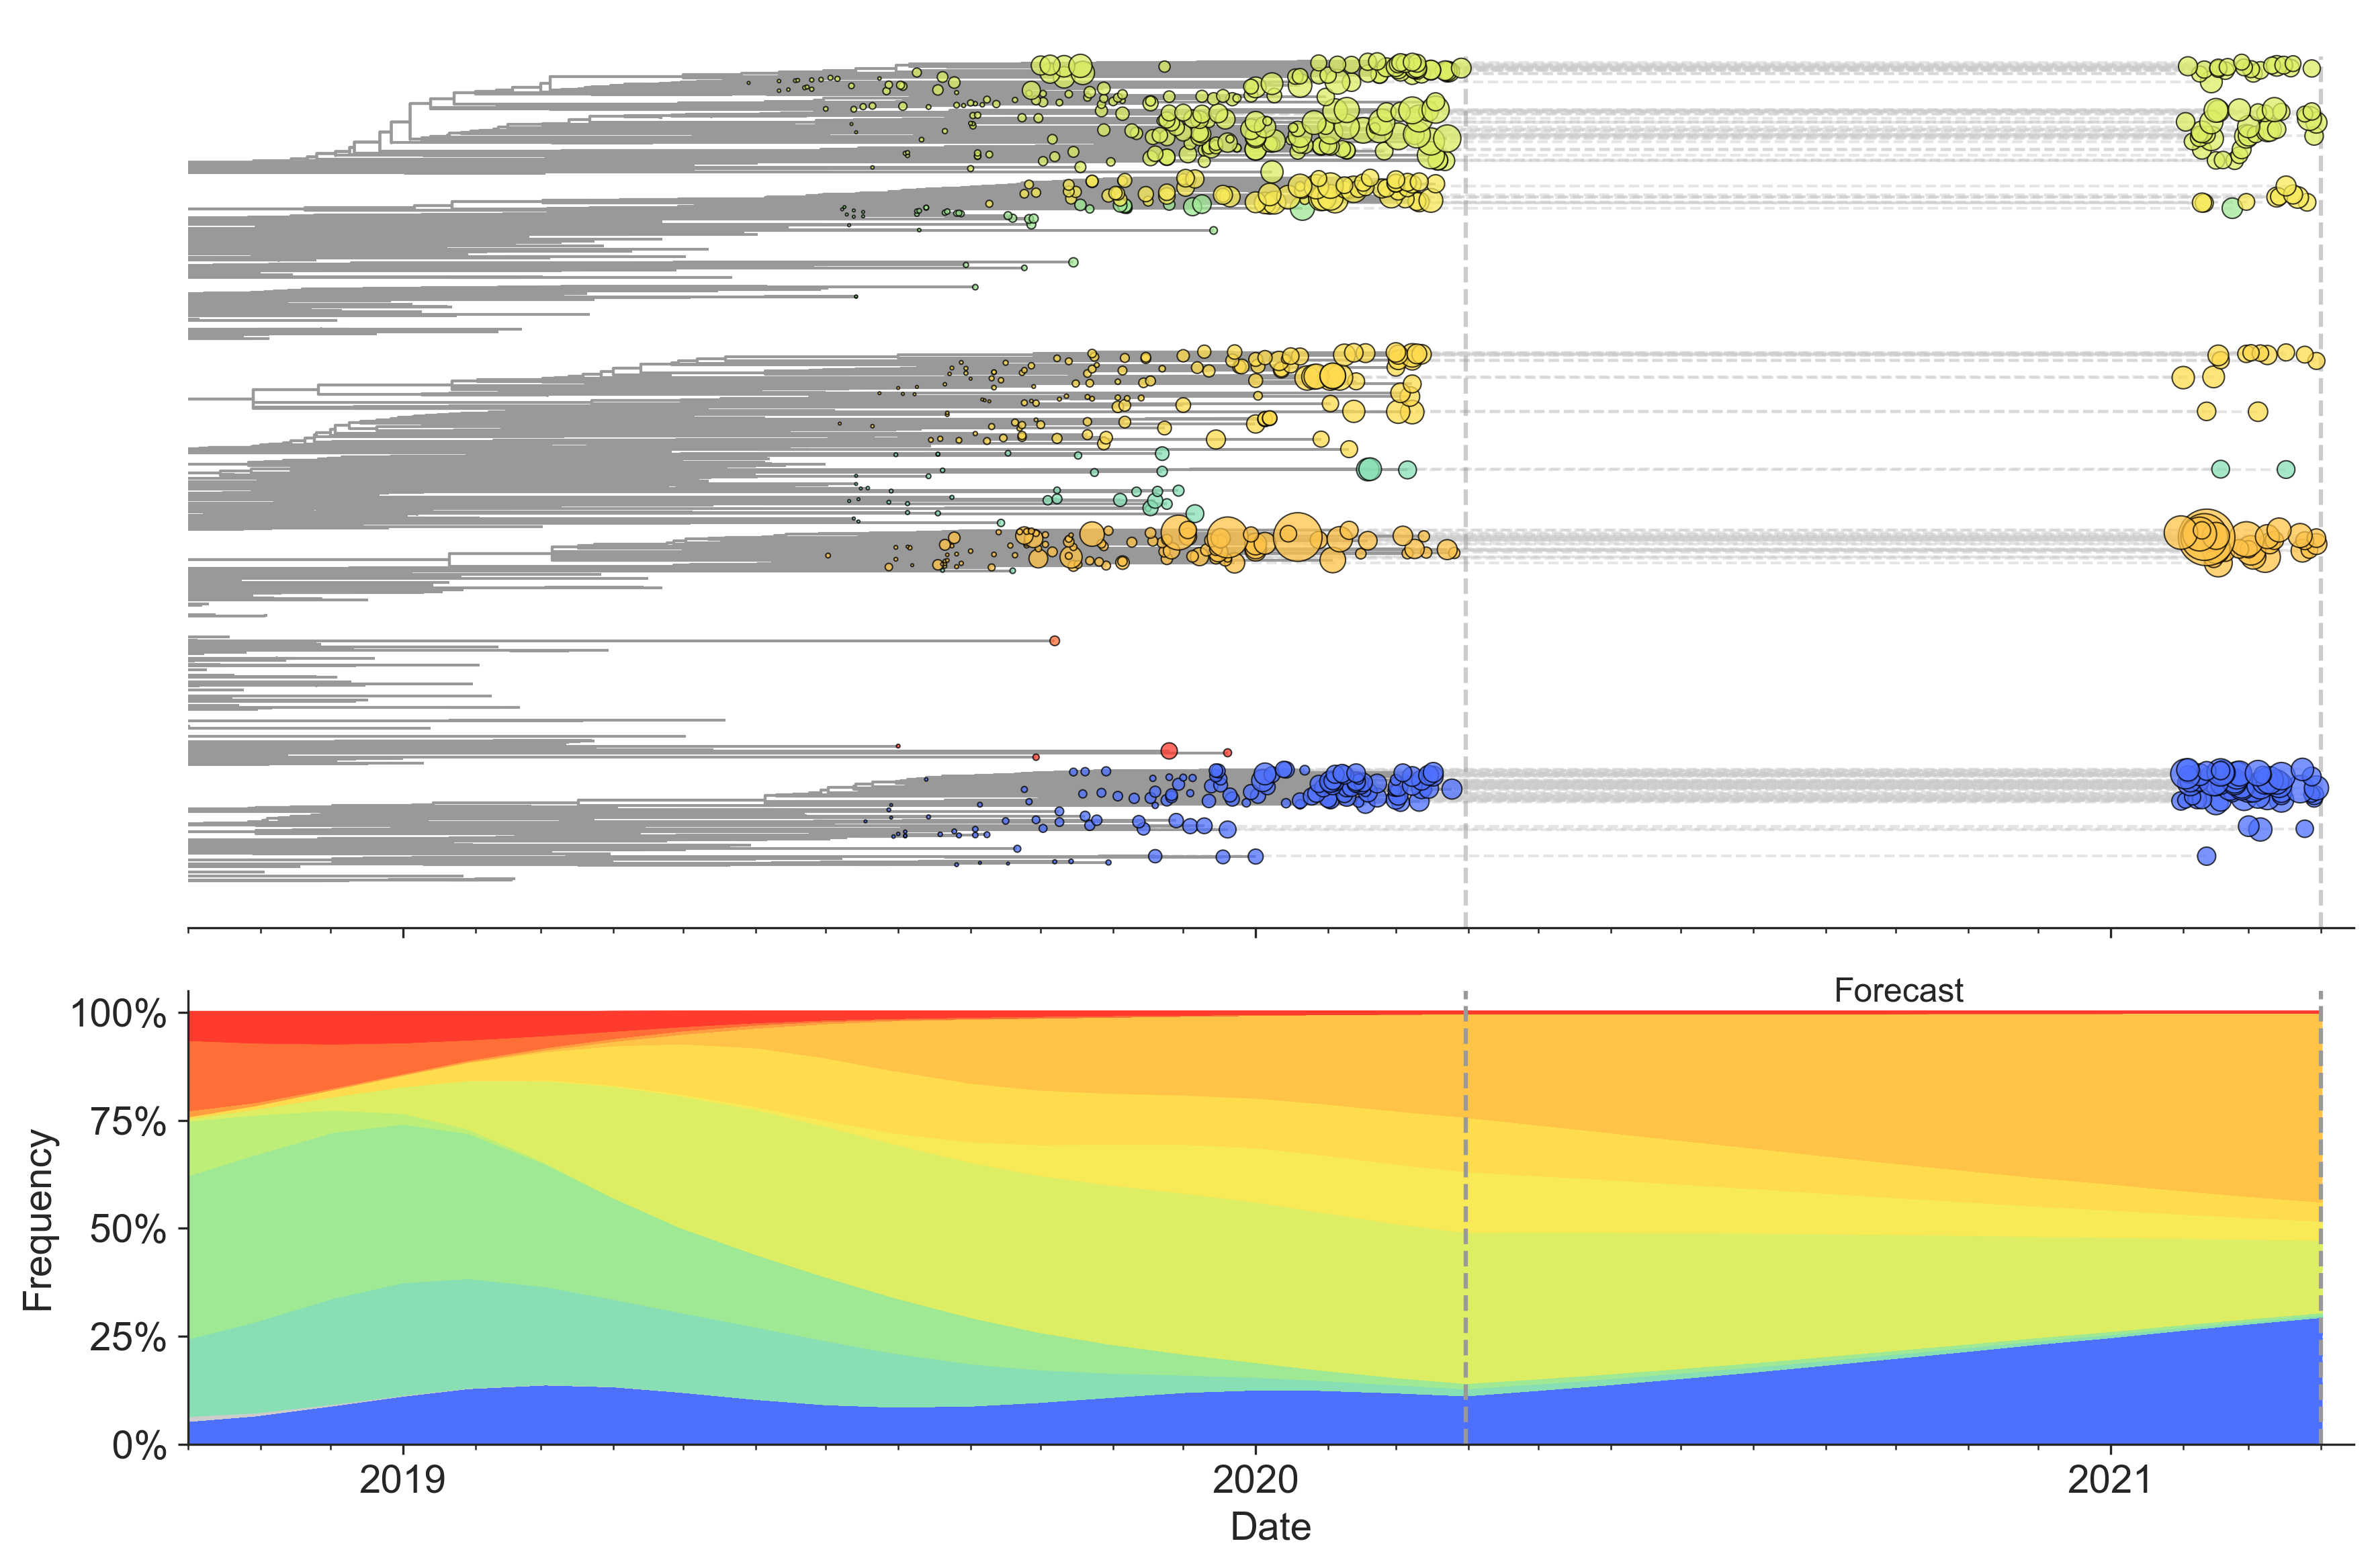

In [57]:
fig = plt.figure(figsize=(12, 8), facecolor='w')
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.5], hspace=0.25, wspace=0.1)

# Tree plot for timepoint t

tree_ax = fig.add_subplot(gs[0])    
tree_ax, colorbar_ax = plot_tree_by_datetime(
    tree_for_t,
    color_by_trait="clade_membership",
    size_by_trait="frequency_at_t",
    ax=tree_ax,
    start_date=start_date,
    end_date=end_date,
    tip_size=tip_size,
    initial_branch_width=1,
    plot_projection_from_date=timepoint_t,
    plot_projection_to_date=timepoint_u,
    projection_attr="projected_frequency",
    projection_line_threshold=0.001,
    cmap=cmap_for_tree
)

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter("%Y")
months = mdates.MonthLocator()

tree_ax.xaxis.set_major_locator(years)
tree_ax.xaxis.set_major_formatter(years_fmt)
tree_ax.xaxis.set_minor_locator(months)
tree_ax.format_xdata = mdates.DateFormatter("%b %Y")

"""tree_ax.text(0.46, 1.0, "$\mathbf{x}(t)$", 
             horizontalalignment='center',
             verticalalignment='center',
             transform=tree_ax.transAxes,
             fontdict={"fontsize": 14})
tree_ax.text(0.94, 1.0, "$\mathbf{\hat{x}}(u)$", 
             horizontalalignment='center',
             verticalalignment='center',
             transform=tree_ax.transAxes,
             fontdict={"fontsize": 14})
"""
tree_ax.axvline(x=timepoint_t, ymax=0.96, color="#999999", linestyle="--", alpha=0.5)
tree_ax.axvline(x=timepoint_u, ymax=0.96, color="#999999", linestyle="--", alpha=0.5)

# Frequency plot for timepoint t

frequency_ax = fig.add_subplot(gs[1])
baseline = np.zeros_like(pivots)
for strain, strain_df in frequency_df_for_t.groupby(["label", "strain"]):
    frequency_ax.fill_between(
        strain_df["ordinal_timepoint"].values,
        baseline, baseline + strain_df["frequency"].values,
        color=strain_df["color"].unique()[0]
    )
    baseline = baseline + strain_df["frequency"].values

frequency_ax.axvline(x=timepoint_t, color="#999999", linestyle="--")
frequency_ax.axvline(x=timepoint_u, color="#999999", linestyle="--")    

frequency_ax.text(
    0.79,
    0.995,
    "Forecast",
    horizontalalignment="center",
    verticalalignment="center",
    transform=frequency_ax.transAxes,
    fontdict={"fontsize": 12}
)

frequency_ax.set_yticks(frequency_steps)
frequency_ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in frequency_steps])
frequency_ax.set_ylabel("Frequency")
frequency_ax.set_xlabel("Date")

frequency_ax.set_xlim(start_date, end_date)
frequency_ax.set_ylim(bottom=0.0)

frequency_ax.xaxis.set_major_locator(years)
frequency_ax.xaxis.set_major_formatter(years_fmt)
frequency_ax.xaxis.set_minor_locator(months)
frequency_ax.format_xdata = mdates.DateFormatter("%Y")

fig.autofmt_xdate(rotation=0, ha="center")

gs.tight_layout(fig, h_pad=1.0)

plt.savefig(distance_model_figure)